In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
path = Path(os.getcwd())
sys.path.append(str(path.parent.absolute()))
from collections import defaultdict
from tqdm import tqdm
import pickle
from commons import *

In [2]:
! ls ../data/archive

PP_recipes.csv              ingr_map.pkl
PP_users.csv                interactions_test.csv
RAW_interactions.csv        interactions_train.csv
RAW_recipes.csv             interactions_validation.csv


In [3]:
preprocessed_recipes = pd.read_csv('../data/archive/PP_recipes.csv')
preprocessed_recipes.head(5)

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


In [4]:
interractions_train = pd.read_csv('../data/archive/interactions_train.csv')
interractions_train.head(5)

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [5]:
raw_recipes = pd.read_csv('../data/archive/RAW_recipes.csv')
raw_recipes.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [6]:
raw_users = pd.read_csv('../data/archive/RAW_interactions.csv')
raw_users.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [69]:
ratingsPerRecipe = defaultdict(list)
for index, row in raw_users.iterrows():
    ratingsPerRecipe[row['recipe_id']].append(row['rating'])

In [70]:
avgRatingsPerRecipe = {}
for recipe_id, ratings in ratingsPerRecipe.items():
    avgRatingsPerRecipe[recipe_id] = np.mean(ratings)

In [71]:
# get time taken to cook
timeTakenPerRecipe = {}
for index, row in raw_recipes.iterrows():
    timeTakenPerRecipe[row['id']] = row['minutes']

In [72]:
# get number of ingredients
numIngredientsPerRecipe = {}
for index, row in raw_recipes.iterrows():
    numIngredientsPerRecipe[row['id']] = len(row['ingredients'].split(','))


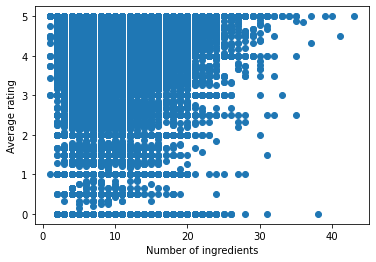

In [73]:
#plot number of ingredients vs avg rating
plt.scatter(list(numIngredientsPerRecipe.values()), list(avgRatingsPerRecipe.values()))
plt.xlabel('Number of ingredients')
plt.ylabel('Average rating')
plt.savefig('plots/numIngredientsVsAvgRating.png', bbox_inches='tight')

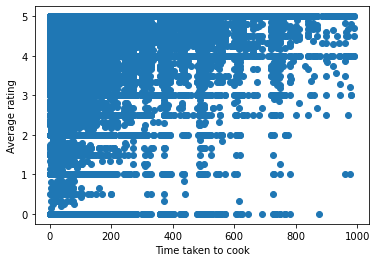

In [74]:
# plot time taken to cook vs avg rating
# plot only recipes that take less than 1000 minutes to cook
timeTakenPerRecipe = {k: v for k, v in timeTakenPerRecipe.items() if v < 1000}
# get avg ratings for recipes that take less than 1000 minutes to cook
avgRatingsPerRecipe = {k: v for k, v in avgRatingsPerRecipe.items() if k in timeTakenPerRecipe.keys()}
plt.scatter(list(timeTakenPerRecipe.values()), list(avgRatingsPerRecipe.values()))
plt.xlabel('Time taken to cook')
plt.ylabel('Average rating')
plt.savefig('plots/timeTakenVsAvgRating.png', bbox_inches='tight')

In [77]:
# plot histogram of avg ratings
# express avg ratings as percentages
avgRatingsPerRecipe = {k: v*100 for k, v in avgRatingsPerRecipe.items()}
plt.hist(list(avgRatingsPerRecipe.values()))
plt.xlabel('Average rating')
plt.ylabel('Number of recipes')
plt.savefig('plots/avgRatingHistogram.png', bbox_inches='tight')

NameError: name 'avgRatingsPerRecipe' is not defined

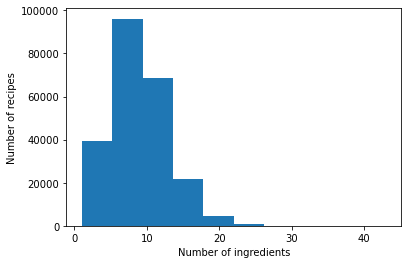

In [76]:
# plot histogram of number of ingredients
plt.hist(list(numIngredientsPerRecipe.values()))
plt.xlabel('Number of ingredients')
plt.ylabel('Number of recipes')
plt.savefig('plots/numIngredientsHistogram.png', bbox_inches='tight')

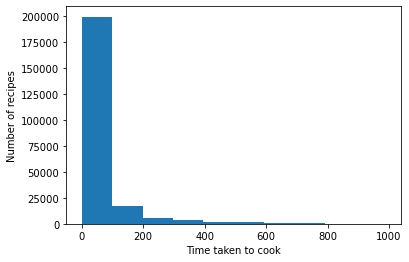

In [77]:
# plot histogram of time taken to cook
plt.hist(list(timeTakenPerRecipe.values()))
plt.xlabel('Time taken to cook')
plt.ylabel('Number of recipes')
plt.savefig('plots/timeTakenHistogram.png', bbox_inches='tight')

In [31]:
recipe_features = ['timeTaken', 'numIngredients', 'nutrition', 'numberOfSteps']
lookup = defaultdict(dict)
for i in tqdm(range(len(raw_recipes))):
    recipe_id = raw_recipes.iloc[i]['id']
    lookup[recipe_id]['timeTaken'] = int(raw_recipes.iloc[i]['minutes'])
    lookup[recipe_id]['numIngredients'] = len(raw_recipes.iloc[i]['ingredients'].split(','))
    lookup[recipe_id]['nutrition'] = raw_recipes.iloc[i]['nutrition']
    lookup[recipe_id]['numberOfSteps'] = int(raw_recipes.iloc[i]['n_steps'])

100%|██████████| 231637/231637 [00:32<00:00, 7123.26it/s]


In [7]:
# calculate average rating for each user from training data
ratingsPerUser = defaultdict(list)
for index, row in tqdm(interractions_train.iterrows()):
    ratingsPerUser[row['user_id']].append(row['rating'])

avgRatingPerUser = defaultdict(float)
for user_id, ratings in ratingsPerUser.items():
    avgRatingPerUser[user_id] = np.mean(ratings)

ratingsPerRecipe = defaultdict(list)
for index, row in tqdm(interractions_train.iterrows()):
    ratingsPerRecipe[row['recipe_id']].append(row['rating'])

avgRatingPerRecipe = defaultdict(float)
for recipe_id, ratings in ratingsPerRecipe.items():
    avgRatingPerRecipe[recipe_id] = np.mean(ratings)

698901it [00:08, 77979.10it/s]
698901it [00:09, 76279.96it/s]


In [32]:
x = []
y = []
pairs = []
for index, row in tqdm(interractions_train.iterrows()):
    user_id = row['user_id']
    recipe_id = row['recipe_id']
    rating = row['rating']
    timeTaken = lookup[recipe_id]['timeTaken']
    numIngredients = lookup[recipe_id]['numIngredients']
    nutrition = eval(lookup[recipe_id]['nutrition'])
    numberOfSteps = lookup[recipe_id]['numberOfSteps']
    avgRatingForUser = avgRatingPerUser[user_id]
    avgRatingForRecipe = avgRatingPerRecipe[recipe_id]
    data = [timeTaken, numIngredients, numberOfSteps, avgRatingForUser, avgRatingForRecipe]
    data.extend(nutrition)
    label = rating
    x.append(data)
    y.append(label)
    pairs.append((user_id, recipe_id))

698901it [00:18, 37972.93it/s]


In [33]:
# normalise data
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)



In [34]:
x.shape

(698901, 12)

In [35]:
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
trainData = [(x[i], y[i]) for i in (tqdm(range(len(x))))]

100%|██████████| 698901/698901 [00:00<00:00, 4068229.24it/s]


In [36]:
# save train data
with open('data/trainData.pkl', 'wb') as f:
    pickle.dump(trainData, f)

In [68]:
with open('data/trainData.pkl', 'rb') as f:
    trainData = pickle.load(f)
x = np.array([x for x, _ in trainData])
y = np.array([y for _, y in trainData])

In [69]:
# get top 2 principal components of x
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)

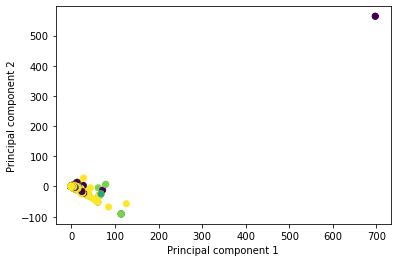

In [70]:
# plot top 2 principal components and color code by rating
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.savefig('plots/pca.png', bbox_inches='tight')

In [71]:
# remove outliers from x with component 1 > 150
outliers = []
for i in (tqdm(range(len(x_pca)))):
    if x_pca[i][0] > 150:
        outliers.append(1)
    else:
        outliers.append(0)

outliers = np.array(outliers)

x = x[outliers == 0]
x_pca = PCA(n_components=2).fit_transform(x)
y = y[outliers == 0]

100%|██████████| 698901/698901 [00:00<00:00, 1014834.16it/s]


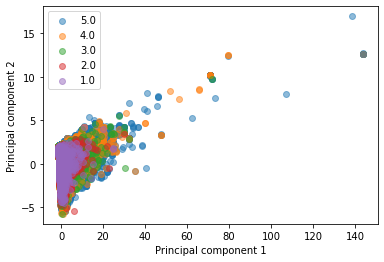

In [74]:
# plot top 2 principal components and color code by rating
# also add legend
label = np.unique(y)
for i in range(len(label)-1, 0, -1):
    plt.scatter(x_pca[y == label[i], 0], x_pca[y == label[i], 1], label=label[i], alpha=0.5)
    plt.legend()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.savefig('plots/pca.png', bbox_inches='tight')


In [66]:
#perform SVD on x
with open('data/trainData.pkl', 'rb') as f:
    trainData = pickle.load(f)
x = np.array([x for x, _ in trainData])
y = np.array([y for _, y in trainData])
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
svd.fit(x)
x_svd = svd.transform(x)

# find outliers
outliers = []
for i in (tqdm(range(len(x_svd)))):
    if x_svd[i][0] > 150:
        outliers.append(1)
    else:
        outliers.append(0)

outliers = np.array(outliers)
x = x[outliers == 0]
x_svd = TruncatedSVD(n_components=2).fit_transform(x)
y = y[outliers == 0]




100%|██████████| 698901/698901 [00:00<00:00, 829285.29it/s]


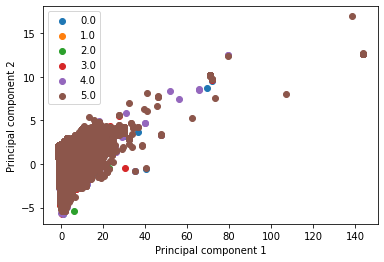

In [67]:
# plot top 2 principal components and color code by rating
label = np.unique(y)
for i in range(len(label)):
    plt.scatter(x_svd[y == label[i], 0], x_svd[y == label[i], 1], label=label[i])
    plt.legend()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.savefig('plots/svd.png', bbox_inches='tight')

In [75]:
with open('data/trainData.pkl', 'rb') as f:
    trainData = pickle.load(f)
x = np.array([x for x, _ in trainData])
y = np.array([y for _, y in trainData])

# concatenate x with y
x = np.concatenate((x, y.reshape(-1, 1)), axis=1)

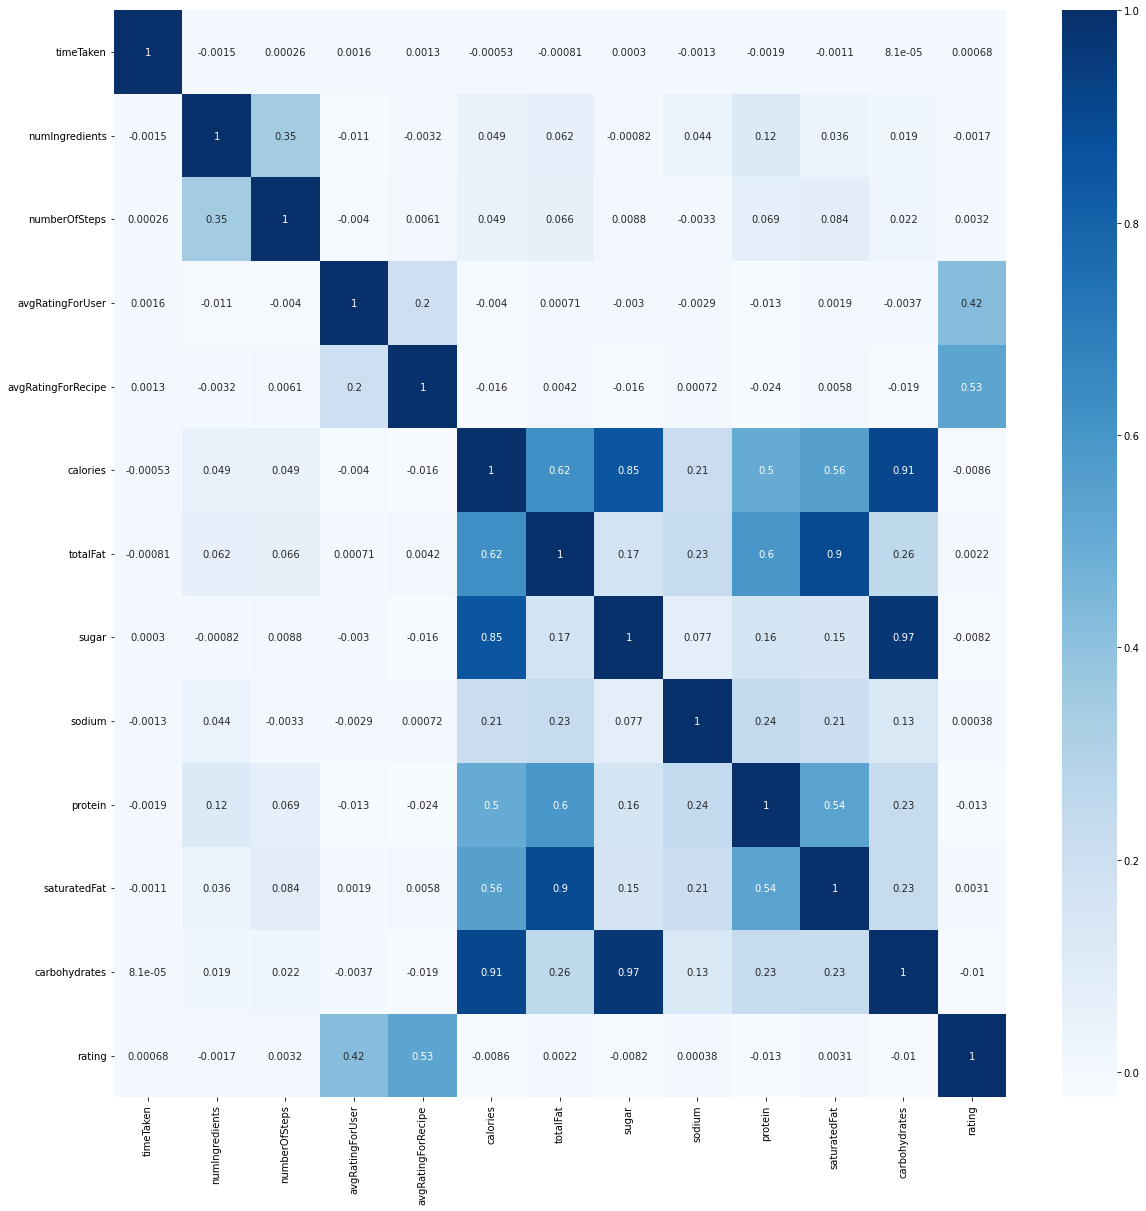

In [80]:
# get heatmap of correlation between features
# increase figure size
features = ['timeTaken', 'numIngredients', 'numberOfSteps', 'avgRatingForUser', 'avgRatingForRecipe', 'calories', 'totalFat', 'sugar', 'sodium', 'protein', 'saturatedFat', 'carbohydrates', 'rating']
plt.rcParams['figure.figsize'] = [20, 20]
import seaborn as sns
corr = pd.DataFrame(x).corr()
sns.heatmap(corr, xticklabels=features, yticklabels=features, annot=True, cmap='Blues')
plt.savefig('plots/correlationHeatmap.png', bbox_inches='tight')
